# 🌊 Wave Data Downloader and Analyzer – Copernicus Marine Services

This notebook guides you through the process of **downloading, analyzing, and visualizing wave data** from the  
**Copernicus Marine Environment Monitoring Service (CMEMS)** using real global wave model outputs.

You will learn how to:

- 🧭 Define a **region of interest** (AOI), a **virtual wave buoy**, and a **site of interest (SOI)**
- 📡 Download wave reanalysis data using the `copernicusmarine` API
- 📈 Plot and analyze wave parameters such as:
  - **Significant wave height** (Hs)
  - **Peak wave period** (Tp)
  - **Wave direction** (VMDR)
- ⏳ Interactively **select time ranges** for subsetting wave records
- 🔍 Identify and analyze **extreme wave events** (storms) using percentiles and time-based grouping
- 📊 Estimate **return periods** for extreme waves using:
  - **Gumbel** and **GEV** fits
  - **Confidence intervals**
  - 📁 Export of return level tables to CSV
- 🗺 Explore **temporal trends** using:
  - Monthly climatology heatmaps
  - Wave direction frequency maps
  - **Anomaly heatmaps** to detect unusual seasons or trends

---

The notebook is designed to be **student-friendly**, with clear input sections, visual plots, and step-by-step explanations.  
It is ideal for courses in **oceanography**, **marine climate**, **coastal engineering**, or **environmental data analysis**.

> ✅ **Requirements:**  
> - A free Copernicus Marine account (to access data)  
> - Your personal credentials saved in the `.netrc` file (the notebook will guide you)  
> - Google Colab (recommended) or a local Python environment with internet access

---

Let’s get started! 🚀

## 📦 Install Required Python Libraries

Before we begin, we need to install a few external libraries that are **not pre-installed in Google Colab**:

- `copernicusmarine`: allows access to Copernicus Marine datasets via their API
- `windrose`: provides easy plotting of wind and wave roses
- `cartopy`: enables geospatial plotting with map projections

> ⚠️ This step only needs to be done **once per session**.  
> If you restart the runtime, run this cell again.

In [25]:
!pip install --quiet copernicusmarine windrose cartopy plotly

## 🧰 Import Required Libraries

In this cell, we import all the Python libraries needed throughout the notebook:

- **Core tools** like `numpy`, `pandas`, and `xarray` for data processing
- **Plotting libraries** such as `matplotlib` and `windrose` for visualizing wave parameters
- **Cartopy** for creating geospatial maps with coastlines and projections
- **Astropy** for time manipulation (helpful for working with model time steps)
- **copernicusmarine** for accessing wave data from the Copernicus Marine Environment Monitoring Service
- **Google Colab integration** to mount and interact with your Google Drive

> You don’t need to change anything in this cell.

In [26]:
# Ignore warnings to keep the notebook clean
import warnings
warnings.filterwarnings('ignore')
# File and OS handling
import os
import shutil
# Core libraries for data analysis
import numpy as np
import pandas as pd
import xarray as xr
# Plotting tools
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from mpl_toolkits.axes_grid1 import make_axes_locatable
from windrose import WindroseAxes
import seaborn as sns
# Geospatial mapping with Cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Time utilities
from astropy.time import Time, TimeDelta
# Access to Copernicus Marine Service API
import copernicusmarine
# Google Drive integration (for saving and loading data)
from google.colab import drive
# Scipy tools
from scipy.ndimage import zoom
from scipy.stats import gumbel_r, genextreme
import scipy.stats as stats

import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go

## 📂 Mount Google Drive and Set Your Working Directory

In this step, we:

- Mount your **Google Drive** to allow file saving/loading
- Define a **working folder** where all project files will be stored
- Create two subfolders:
  - `output_data`: to store any downloaded or processed datasets
  - `output_images`: to store plots and figures

> ⚠️ **IMPORTANT:**  
> Edit the `working_dir` variable to match the folder in your Google Drive where you're working.  
> For example:  
> `/content/drive/MyDrive/YourClassFolder/YourProjectName/`

In [27]:
# Mount your Google Drive
drive.mount('/content/drive')

# ⚠️⚠️ EDIT THIS PATH to point to the folder where you're working ⚠️⚠️
working_dir = '/content/drive/MyDrive/Coastal_hydrodynamics/'
os.makedirs(working_dir, exist_ok=True)
os.chdir(working_dir)

# Create folders for storing outputs
os.makedirs('output_data', exist_ok=True)
os.makedirs('output_images', exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 🌍 Define and Visualize Area of Interest, Site of Interest, and Virtual Buoy

In this step, you will define three important spatial components for your analysis:

---

### 🔷 **AOI (Area of Interest)**  
This is the rectangular area from which wave data will be downloaded.  
> ⚠️ It must be at least **0.5° × 0.5°** in size to ensure it includes enough grid points from the Copernicus wave model (resolution ~1/5°).

🎯 **Tip:** Use [bboxfinder.com](https://bboxfinder.com/) to easily define your area.  
- Choose your region by dragging a box on the map  
- Copy the coordinates into the notebook (min/max latitude and longitude)

---

### 🟢 **SOI (Site of Interest)**  
This is a specific coastal point of interest (e.g. a beach, reef, or harbor).  
You can give it a custom name and specify its latitude and longitude.

---

### 🔴 **Virtual Buoy**  
This is where we will extract a **time series** of wave parameters (height, period, etc.)  
You can place it anywhere: inside the AOI or slightly offshore from the SOI.

---

After defining these coordinates, a map will be generated with:
- **AOI** outlined in **blue**
- **Virtual buoy** marked with a **red dot**
- **SOI** marked with a **green dot**

> ✍️ **Edit only the USER INPUT section** above the horizontal line in the code cell.  
> Do not modify the rest unless you're confident in what you're doing.

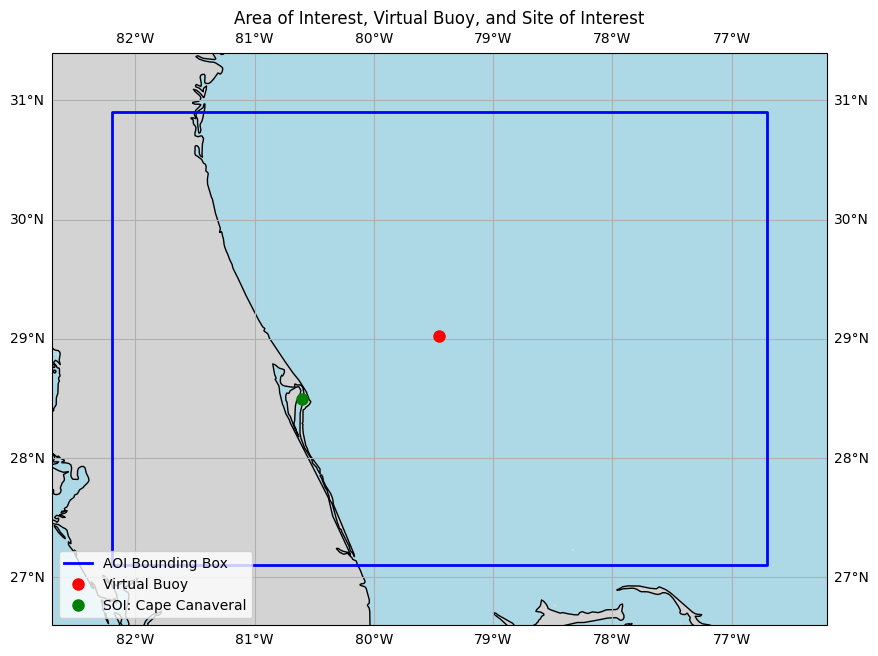

In [28]:
# --------------------------------------------------------------------------------
# 🔧 USER INPUT SECTION: Define the Area of Interest (AOI), Site of Interest (SOI),
#     and coordinates for the Virtual Buoy (can be placed anywhere)
# --------------------------------------------------------------------------------

# AOI Bounding Box (must be at least 1° x 1°)
min_lon = -82.2   # 🔧 West boundary
max_lon = -76.7   # 🔧 East boundary
min_lat = 27.1    # 🔧 South boundary
max_lat = 30.9    # 🔧 North boundary

# Site of Interest (SOI)
SOI_name = 'Cape Canaveral'   # 🔧 Custom name for the SOI
lon_SOI = -80.6             # 🔧 Longitude of SOI
lat_SOI = 28.5              # 🔧 Latitude of SOI

# Virtual Buoy (freely placed within or outside AOI)
target_lon = -79.453125          # 🔧 Longitude of virtual buoy
target_lat = 29.027355          # 🔧 Latitude of virtual buoy

# --------------------------------------------------------------------------------
# ✅ DO NOT EDIT BELOW THIS LINE UNLESS YOU KNOW WHAT YOU'RE DOING
# --------------------------------------------------------------------------------

# Check AOI size (Copernicus grid resolution is ~1/5°)
if (max_lon - min_lon) < 1 or (max_lat - min_lat) < 1:
    raise ValueError("❗ AOI must be at least 1° × 1° for Copernicus model resolution.")

# --- Plot with Cartopy ---
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent with a margin
margin = 0.5
ax.set_extent([min_lon - margin, max_lon + margin, min_lat - margin, max_lat + margin])

# Add map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.gridlines(draw_labels=True)

# Plot AOI rectangle
aoi_lon = [min_lon, max_lon, max_lon, min_lon, min_lon]
aoi_lat = [min_lat, min_lat, max_lat, max_lat, min_lat]
ax.plot(aoi_lon, aoi_lat, color='blue', linewidth=2, label='AOI Bounding Box', transform=ccrs.Geodetic())

# Plot Virtual Buoy
ax.plot(target_lon, target_lat, 'ro', markersize=8, label='Virtual Buoy', transform=ccrs.PlateCarree())

# Plot SOI
ax.plot(lon_SOI, lat_SOI, 'go', markersize=8, label=f'SOI: {SOI_name}', transform=ccrs.PlateCarree())

# Add legend and title
ax.legend(loc='lower left')
plt.title("Area of Interest, Virtual Buoy, and Site of Interest")
plt.savefig(os.path.join('output_images','AOI_SOI_VB.pdf'),transparent=True,dpi=500)
plt.show()

## 🌊 Download Wave Data from Copernicus Marine Services

In this step, we will download global wave reanalysis data using the product:

> **GLOBAL_REANALYSIS_WAV_001_032**  
> This dataset provides **past sea state conditions** from **January 15, 1980** to **April 2023**.  
> It includes 3-hourly wave statistics at a **0.2° spatial resolution** on a global grid.

🔗 **Product DOI:** [https://doi.org/10.48670/moi-00022](https://doi.org/10.48670/moi-00022)  
📄 **Reference:**  
Law-Chune, S., Aouf, L., Dalphinet, A. et al.  
*WAVERYS: a CMEMS global wave reanalysis during the altimetry period*.  
Ocean Dynamics 71, 357–378 (2021).  
[https://doi.org/10.1007/s10236-020-01433-w](https://doi.org/10.1007/s10236-020-01433-w)

---

### 🧰 Required steps:
1. **Login to Copernicus Marine** using your account  
2. **Download the wave data** for your AOI and time range  
   (you only need to do this **once**, data will be saved)

> 👉 If you haven’t already, create a free Copernicus Marine account at  
> [https://data.marine.copernicus.eu/](https://data.marine.copernicus.eu/)

In [ ]:
copernicusmarine.login()

INFO - 2025-05-03T20:12:39Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register
INFO:copernicusmarine:Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: arovere
Copernicus Marine password: ··········


INFO - 2025-05-03T20:12:50Z - Credentials file stored in /root/.copernicusmarine/.copernicusmarine-credentials.
INFO:copernicusmarine:Credentials file stored in /root/.copernicusmarine/.copernicusmarine-credentials.


True

## 📡 Interrogating the Copernicus Wave Dataset

We now query and download wave data from the Copernicus Marine Service, covering the time range:

> **January 15, 1980 to January 15, 2023**

We extract the following wave attributes:

1. **VHM0 [m]** – Spectral significant wave height (Hm0)  
2. **VTPK [s]** – Wave period at spectral peak (Tp)  
3. **VMDR [°]** – Mean wave direction (Mdir)

📁 The data will be saved in the folder: `output_data`

📄 The filename will include your **Site of Interest name (SOI)**.

> ⚠️ **Note:** If you've already run this step and the file exists in your folder, you can safely skip it.

> ⏳ Downloading may take several minutes depending on your connection and AOI size.

In [ ]:
# Helper function to clear the output/data folder (optional)
def clear_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        os.makedirs(folder_path)
    else:
        print(f'The folder {folder_path} does not exist.')

# Optional: Clear the output folder before saving new data
folder_path = 'output_data/'
clear_folder(folder_path)

# Download wave reanalysis data
copernicusmarine.subset(
  dataset_id="cmems_mod_glo_wav_my_0.2deg_PT3H-i",
  variables=["VHM0", "VTPK","VMDR"],
  minimum_longitude=min_lon,
  maximum_longitude=max_lon,
  minimum_latitude=min_lat,
  maximum_latitude=max_lat,
  start_datetime="1980-01-15T00:00:00",
  end_datetime="2023-01-15T00:00:00",
  output_filename = SOI_name+"_waves_copernicus.nc",
  output_directory = folder_path
)

INFO - 2025-05-03T20:12:57Z - Selected dataset version: "202411"
INFO:copernicusmarine:Selected dataset version: "202411"
INFO - 2025-05-03T20:12:57Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
INFO - 2025-05-03T20:13:14Z - Starting download. Please wait...
INFO:copernicusmarine:Starting download. Please wait...


  0%|          | 0/1524 [00:00<?, ?it/s]

INFO - 2025-05-03T20:21:11Z - Successfully downloaded to output_data/Cape Canaveral_waves_copernicus.nc
INFO:copernicusmarine:Successfully downloaded to output_data/Cape Canaveral_waves_copernicus.nc


ResponseSubset(file_path=PosixPath('output_data/Cape Canaveral_waves_copernicus.nc'), output_directory=PosixPath('output_data'), filename='Cape Canaveral_waves_copernicus.nc', file_size=369.0469904580152, data_transfer_size=2493.244580152672, variables=['VHM0', 'VTPK', 'VMDR'], coordinates_extent=[GeographicalExtent(minimum=-82.0, maximum=-76.79998779296875, unit='degrees_east', coordinate_id='longitude'), GeographicalExtent(minimum=27.200000762939453, maximum=30.799999237060547, unit='degrees_north', coordinate_id='latitude'), TimeExtent(minimum='1980-01-15T00:00:00+00:00', maximum='2023-01-15T00:00:00+00:00', unit='iso8601', coordinate_id='time')], status='000', message='The request was successful.', file_status='DOWNLOADED')

## 📂 Load the Downloaded Wave Dataset

Now that the data has been downloaded, we open the **NetCDF (`.nc`) file** using `xarray`.

The dataset contains spatial and temporal information about the wave conditions in your selected AOI.  
In the next steps, we’ll extract the values at the location of the **virtual buoy**.

> ⚠️ Make sure the filename and folder match your earlier download step.

In [29]:
folder_path = 'output_data/'
# Construct full path to the NetCDF file
wav_nc = os.path.join(folder_path, SOI_name + "_waves_copernicus.nc")
# Open the dataset using xarray
wav_ds = xr.open_dataset(wav_nc)
# Display dataset structure
wav_ds

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 125649, latitude: 19, longitude: 27)
Coordinates:
  * latitude   (latitude) float32 76B 27.2 27.4 27.6 27.8 ... 30.4 30.6 30.8
  * longitude  (longitude) float32 108B -82.0 -81.8 -81.6 ... -77.2 -77.0 -76.8
  * time       (time) datetime64[ns] 1MB 1980-01-15 ... 2023-01-15
Data variables:
    VHM0       (time, latitude, longitude) float64 516MB ...
    VTPK       (time, latitude, longitude) float64 516MB ...
    VMDR       (time, latitude, longitude) float64 516MB ...
Attributes:
    producer:                  CMEMS - Global Monitoring and Forecasting Centre
    institution:               METEO-FRANCE
    title:                     Mean fields from global wave model MFWAM of Me...
    references:                http://marine.copernicus.eu
    contact:                   servicedesk.cmems@mercator-ocean.eu
    credit:                    E.U. Copernicus Marine Service Information (CM...
    Conventions:               CF-1.6
    copernicusmarine_version:  2.0.1

## 🗺️ Compare Average and Extreme Wave Conditions

This figure shows two panels of wave conditions for your Area of Interest:

- **Left panel:** Overall mean conditions across the full time range  
- **Right panel:** Mean of the **top 10% of wave heights**, representing energetic sea states

Each panel includes:
- Colored contours = significant wave height (**VHM0**)  
- Black contours = peak wave period (**VTPK**)  
- Arrows = mean wave direction (**VMDR**, "from" convention)  
- A white dot = **Virtual Buoy** location

> 📁 The figure is saved as `wave_maps_avg_top10.jpg` in your `output_images/` folder.

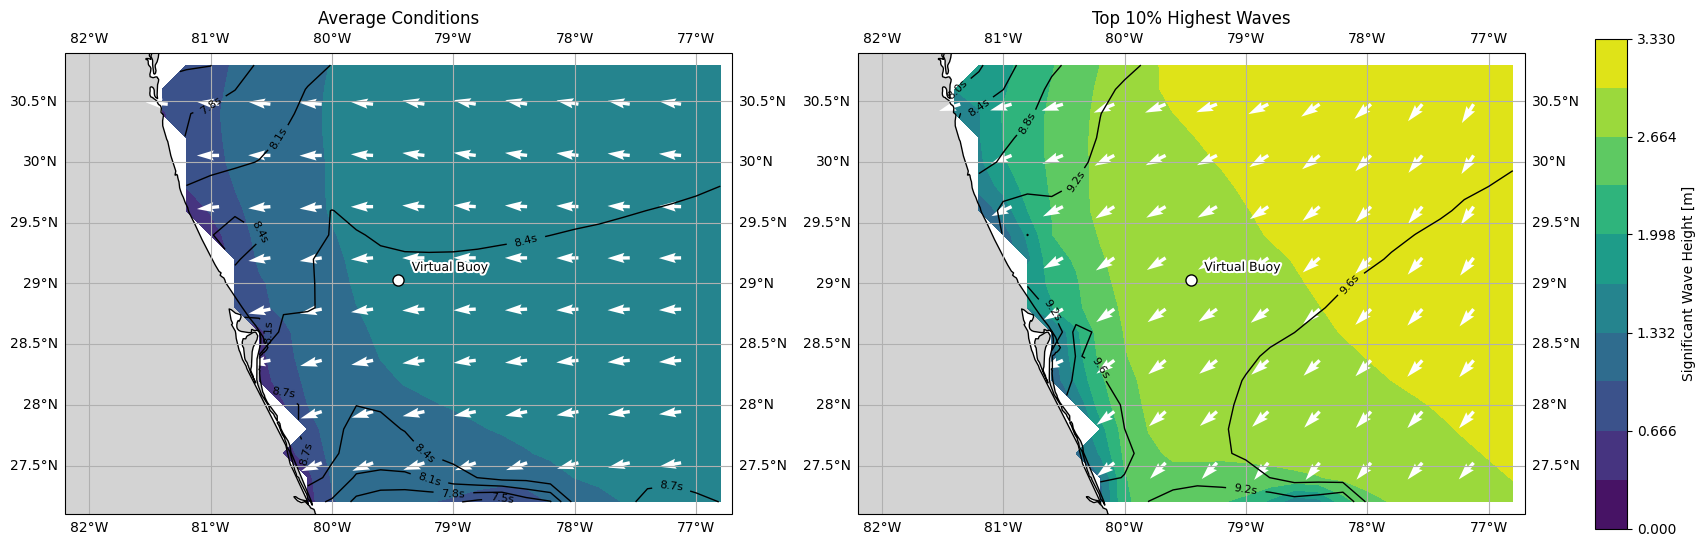

In [30]:
img_dir = 'output_images/'
os.makedirs(img_dir, exist_ok=True)

# ----------------------------------
# 📊 Compute average fields
# ----------------------------------
# Clip Hs and Tp to a minimum value BEFORE calculating the mean
wav_ds['VHM0'] = wav_ds['VHM0'].clip(min=0.001)
wav_ds['VTPK'] = wav_ds['VTPK'].clip(min=0.001)

mean_VHM0 = wav_ds['VHM0'].mean(dim='time')
mean_VTPK = wav_ds['VTPK'].mean(dim='time')

# Circular mean for wave direction
theta_rad = np.radians(wav_ds['VMDR'])
u_all = np.sin(theta_rad)
v_all = np.cos(theta_rad)
u_mean = u_all.mean(dim='time')
v_mean = v_all.mean(dim='time')
mean_VMDR = (np.degrees(np.arctan2(u_mean, v_mean))) % 360
mean_VMDR_reversed = (mean_VMDR + 180) % 360
u_plot_mean = np.sin(np.radians(mean_VMDR_reversed))
v_plot_mean = np.cos(np.radians(mean_VMDR_reversed))

# ----------------------------------
# 🔝 Compute top 10% highest waves
# ----------------------------------
threshold = wav_ds['VHM0'].quantile(0.9, dim='time')
top10_mask = wav_ds['VHM0'] > threshold

VHM0_top10 = wav_ds['VHM0'].where(top10_mask)
VTPK_top10 = wav_ds['VTPK'].where(top10_mask)
VMDR_top10 = wav_ds['VMDR'].where(top10_mask)

mean_VHM0_top10 = VHM0_top10.mean(dim='time')
mean_VTPK_top10 = VTPK_top10.mean(dim='time')

theta_rad_top10 = np.radians(VMDR_top10)
u_top10 = np.sin(theta_rad_top10)
v_top10 = np.cos(theta_rad_top10)
u_mean_top10 = u_top10.mean(dim='time')
v_mean_top10 = v_top10.mean(dim='time')
mean_VMDR_top10 = (np.degrees(np.arctan2(u_mean_top10, v_mean_top10))) % 360
mean_VMDR_reversed_top10 = (mean_VMDR_top10 + 180) % 360
u_plot_top10 = np.sin(np.radians(mean_VMDR_reversed_top10))
v_plot_top10 = np.cos(np.radians(mean_VMDR_reversed_top10))

# ----------------------------------
# 🖼 Plot both maps without smoothing
# ----------------------------------
fig, axs = plt.subplots(1, 2, figsize=(16, 7), subplot_kw={'projection': ccrs.PlateCarree()})
outline = [withStroke(linewidth=3, foreground='white')]

# Define common levels for both plots:
max_wave_height = max(mean_VHM0.max().item(), mean_VHM0_top10.max().item())
levels = np.linspace(0, max_wave_height, 11)  # Adjust max_wave_height accordingly

for ax, vhm0, vtpk, u_plot, v_plot, title in zip(
    axs,
    [mean_VHM0, mean_VHM0_top10],
    [mean_VTPK, mean_VTPK_top10],
    [u_plot_mean, u_plot_top10],
    [v_plot_mean, v_plot_top10],
    ['Average Conditions', 'Top 10% Highest Waves']
):
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='white')
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines(draw_labels=True)

    # Plot wave height as filled contour (no smoothing)
    cs = ax.contourf(vhm0.longitude, vhm0.latitude, vhm0,
                     cmap='viridis', levels=levels, transform=ccrs.PlateCarree(), zorder=1)

    # Plot Tp as line contours (no smoothing)
    vtpk_contours = ax.contour(vtpk.longitude, vtpk.latitude, vtpk,
                               levels=5, colors='black', linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(vtpk_contours, inline=True, fontsize=8, fmt="%.1fs")

    # Direction arrows (no smoothing)
    lon_grid, lat_grid = np.meshgrid(vhm0.longitude, vhm0.latitude)
    ax.quiver(lon_grid, lat_grid, u_plot, v_plot,
              color='white', scale=30, regrid_shape=10, transform=ccrs.PlateCarree())

    # Virtual buoy
    ax.plot(target_lon, target_lat, marker='o', markersize=8, markerfacecolor='white',
            markeredgecolor='black', transform=ccrs.PlateCarree())
    # Calculate dynamic offset based on AOI extent
    lon_offset = (max_lon - min_lon) * 0.02  # 1% of AOI width
    lat_offset = (max_lat - min_lat) * 0.02  # 1% of AOI height

    # Add the text label with adaptive offset
    ax.text(target_lon + lon_offset, target_lat + lat_offset, 'Virtual Buoy',
            color='k', fontsize=9, transform=ccrs.PlateCarree(), path_effects=outline)

    ax.set_title(title)

# Shared vertical colorbar
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
cb = fig.colorbar(cs, cax=cbar_ax, orientation='vertical')
cb.set_label('Significant Wave Height [m]')

plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'wave_maps_avg_top10_smoothed.jpg'), dpi=300, bbox_inches='tight')
plt.show()

## 📈 Time Series at the Virtual Buoy

We now extract the wave conditions at the **virtual buoy** by selecting the closest grid cell in the Copernicus dataset.

We plot:

- **Top panel:** Significant wave height (**VHM0**) over time
- **Bottom panel:** Peak wave period (**VTPK**) over time

This gives an overview of the local wave climate at your point of interest.

> 📁 The figure is saved as `virtual_buoy_time_series.jpg` in your `output_images/` folder.

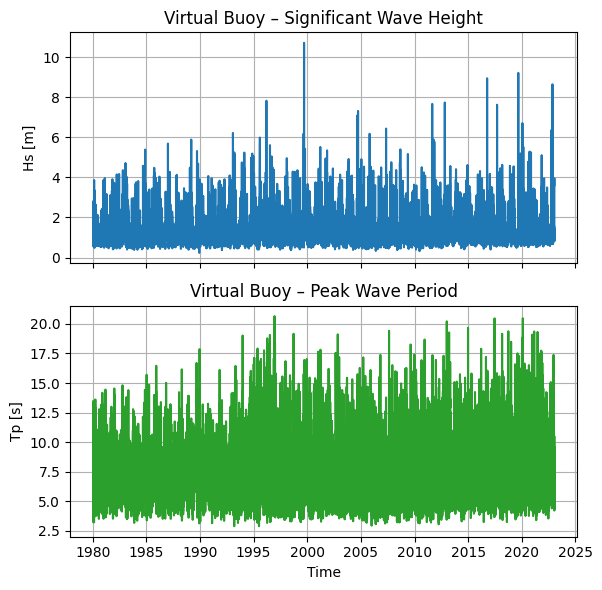

In [31]:
# Extract time series at the virtual buoy using nearest grid point
buoy_data = wav_ds.sel(
    longitude=target_lon,
    latitude=target_lat,
    method='nearest'
)

# Extract time, wave height, and peak period
time = buoy_data['time']
hs = buoy_data['VHM0']  # Significant wave height
tp = buoy_data['VTPK']  # Peak wave period

# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# Top panel: Hs
axs[0].plot(time, hs, color='tab:blue')
axs[0].set_ylabel('Hs [m]')
axs[0].set_title('Virtual Buoy – Significant Wave Height')
axs[0].grid(True)

# Bottom panel: Tp
axs[1].plot(time, tp, color='tab:green')
axs[1].set_ylabel('Tp [s]')
axs[1].set_title('Virtual Buoy – Peak Wave Period')
axs[1].set_xlabel('Time')
axs[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'virtual_buoy_time_series.jpg'), dpi=300, bbox_inches='tight')
plt.show()

## 🌬️ Wave Rose at the Virtual Buoy

This diagram shows a **wave rose**, which summarizes:

- The **direction waves come from** (using the `VMDR` variable)
- The **significant wave height (VHM0)** in each direction
- Frequencies are **normalized** (each bar shows % of total occurrence)

This is useful to visualize **dominant wave directions** and their energy.

> 📁 The rose diagram is saved as `wave_rose_virtual_buoy.pdf` in your `output_images/` folder.

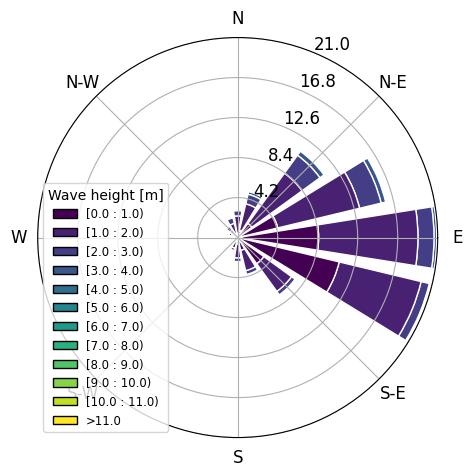

In [32]:
from windrose import WindroseAxes

# Create a windrose-style plot for wave height by direction
fig = plt.figure(figsize=(5, 5))
ax = WindroseAxes.from_ax(fig=fig)

max_height = buoy_data['VHM0'].max().item()  # get max value as float
rounded_max = np.ceil(max_height * 2) / 2    # round up to nearest 0.5

ax.bar(
    buoy_data['VMDR'].values,
    buoy_data['VHM0'].values,
    normed=True,
    opening=0.8,
    edgecolor='white',
    bins=np.arange(0, rounded_max + 0.5, 1)
)

# Styling
ax.legend(title='Wave height [m]', fontsize='small')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Save to output folder
plt.savefig(os.path.join(img_dir, 'wave_rose_virtual_buoy.pdf'), transparent=True, dpi=500)
plt.show()

## 💾 Export Virtual Buoy Data

Now that we have extracted wave conditions at the **virtual buoy**, we export this data to a `.csv` file for further analysis or visualization.

The exported file includes:
- `time` – Timestamp of each observation  
- `VHM0` – Significant wave height (in meters)  
- `VTPK` – Peak wave period (in seconds)  
- `VMDR` – Mean wave direction (*from* direction, in degrees)

> 📁 The CSV file is saved in your `output_data/` folder as:

In [33]:
# Convert buoy data to a Pandas DataFrame
buoy_df = buoy_data[['VHM0', 'VTPK', 'VMDR']].to_dataframe().reset_index()

# Save to CSV
csv_path = os.path.join('output_data', 'virtual_buoy_wave_data.csv')
buoy_df.to_csv(csv_path, index=False)

print(f"✅ Data saved to: {csv_path}")

✅ Data saved to: output_data/virtual_buoy_wave_data.csv


## 🕒 Select a Time Interval from the Wave Data

Now that we've loaded wave height and period data from the virtual buoy, it's time to focus on a specific period of interest (e.g., a storm event, calm season, etc.).

Use the steps below:

---

### 👁️ Step 1: Explore the Data Visually

Above, you'll find an **interactive plot** showing:

- **Blue line:** Significant wave height (`Hs`, in meters)
- **Orange line:** Peak wave period (`Tp`, in seconds)

You can **zoom**, **pan**, or use the **range slider** at the bottom to visually identify an interesting time interval.

---

### ✍️ Step 2: Enter the Dates

Below the graph, you'll find two date selection boxes:

- 📅 **Start date:** Choose the beginning of the interval  
- 📅 **End date:** Choose the end of the interval  

> Make sure both dates are filled in and that the start is before the end.

---

### ✅ Step 3: Confirm and Filter

Click the **"Confirm Date Range"** button to:

- Filter the data to your selected interval
- Display how many records were selected
- Store the result in memory for further analysis

You can now use this filtered data to make plots, calculate statistics, or export it as a `.csv` file.

In [34]:
# Convert time to datetime for Plotly
buoy_df['time'] = pd.to_datetime(buoy_df['time'])

# Create figure
fig = go.Figure()

# Add wave height trace (black)
fig.add_trace(go.Scatter(
    x=buoy_df['time'],
    y=buoy_df['VHM0'],
    mode='lines',
    name='Hs [m]',
    line=dict(color='black')
))

# Add wave period trace (orange with transparency)
fig.add_trace(go.Scatter(
    x=buoy_df['time'],
    y=buoy_df['VTPK'],
    mode='lines',
    name='Tp [s]',
    yaxis="y2",
    line=dict(color='darkorange'),
    opacity=0.3
))

# Layout with dual axes and range slider
fig.update_layout(
    title="📈 Wave Height and Peak Period – Virtual Buoy",
    xaxis=dict(title="Time", rangeslider=dict(visible=True), type="date"),
    yaxis=dict(title="Hs [m]", color='royalblue'),
    yaxis2=dict(
        title="Tp [s]",
        overlaying="y",
        side="right",
        color='darkorange'
    ),
    legend=dict(x=0.01, y=0.99),
    height=500,
    template="plotly_white"
)

fig.show()

# Define manual date pickers
start_picker = widgets.DatePicker(
    description='Start date:',
    disabled=False
)

end_picker = widgets.DatePicker(
    description='End date:',
    disabled=False
)

# Button and output
confirm_button = widgets.Button(description="✅ Confirm Date Range")
output = widgets.Output()

# Callback
def on_confirm_clicked(b):
    with output:
        clear_output()
        start_date = pd.to_datetime(start_picker.value)
        end_date = pd.to_datetime(end_picker.value)
        if pd.isnull(start_date) or pd.isnull(end_date):
            print("⚠️ Please select both a start and an end date.")
        elif start_date > end_date:
            print("⚠️ Start date must be before end date.")
        else:
            mask = (buoy_df['time'] >= start_date) & (buoy_df['time'] <= end_date)
            selected_df = buoy_df[mask]
            print(f"📌 Selected range: {start_date} → {end_date}")
            print(f"✅ Extracted {len(selected_df)} records.")
            # Optional: store selected_df globally for future use
            globals()['selected_df'] = selected_df

# Hook it up
confirm_button.on_click(on_confirm_clicked)

# Display
display(start_picker, end_picker, confirm_button, output)

Output hidden; open in https://colab.research.google.com to view.

## 💾 Export the Selected Time Interval to CSV

Once you have selected and confirmed a time interval, you can export the filtered wave data to a `.csv` file for further analysis.

The file will include the following columns:
- `time`: Date and time of each observation
- `VHM0`: Significant wave height (in meters)
- `VTPK`: Peak wave period (in seconds)
- `VMDR`: Mean wave direction (*from* direction, in degrees)

---

### 📂 File Naming

To help you keep track of different intervals, the filename will automatically include the selected start and end dates.

This file is saved to your `output_data/` folder and can be opened in Excel, Python, or any spreadsheet software.

In [35]:
# Make sure selected_df exists and has content
if 'selected_df' in globals() and not selected_df.empty:
    start_str = selected_df['time'].min().strftime('%Y%m%d')
    end_str = selected_df['time'].max().strftime('%Y%m%d')

    filename = f'selected_virtual_buoy_data_{start_str}_to_{end_str}.csv'
    export_path = os.path.join('output_data', filename)

    selected_df.to_csv(export_path, index=False)
    print(f"✅ Selected data exported to:\n{export_path}")
else:
    print("⚠️ No data selected yet. Please confirm a date range first.")

✅ Selected data exported to:
output_data/selected_virtual_buoy_data_20040903_to_20040907.csv


## 🌊 Visualizing Extreme Wave Heights

To begin analyzing extreme wave conditions, we first visualize the full record of **significant wave height (Hs)** from the virtual buoy.

This plot includes:
- A time series of Hs
- Horizontal lines for the **mean**, **90th**, **95th**, and **99th percentiles**

These percentile thresholds are commonly used to define **extreme wave events**.

> 📁 The figure is saved as `wave_height_with_percentiles.png` in your `output_images/` folder.

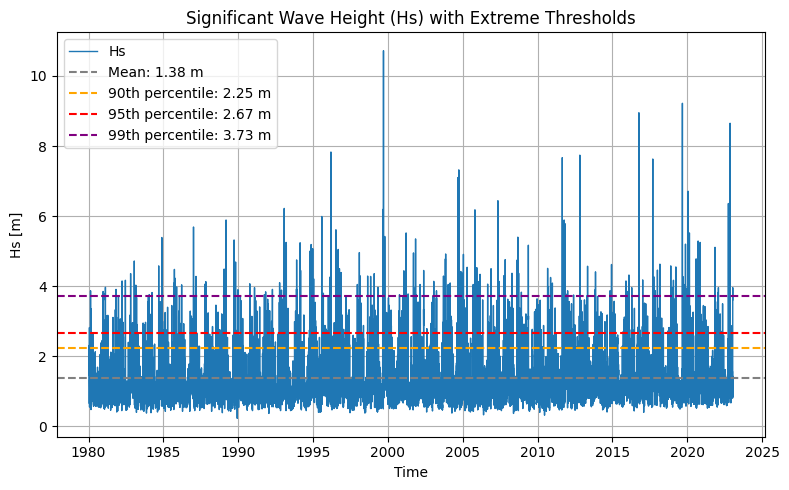

In [36]:
# Calculate key percentiles
p90 = buoy_df['VHM0'].quantile(0.90)
p95 = buoy_df['VHM0'].quantile(0.95)
p99 = buoy_df['VHM0'].quantile(0.99)
mean_hs = buoy_df['VHM0'].mean()

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(buoy_df['time'], buoy_df['VHM0'], label='Hs', color='tab:blue', linewidth=1)

# Add horizontal lines for percentiles and mean
ax.axhline(mean_hs, color='gray', linestyle='--', label=f'Mean: {mean_hs:.2f} m')
ax.axhline(p90, color='orange', linestyle='--', label=f'90th percentile: {p90:.2f} m')
ax.axhline(p95, color='red', linestyle='--', label=f'95th percentile: {p95:.2f} m')
ax.axhline(p99, color='purple', linestyle='--', label=f'99th percentile: {p99:.2f} m')

# Labels and title
ax.set_title('Significant Wave Height (Hs) with Extreme Thresholds')
ax.set_ylabel('Hs [m]')
ax.set_xlabel('Time')
ax.legend()
ax.grid(True)

# Save and show
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'wave_height_with_percentiles.png'), dpi=300)
plt.show()

## 🌪️ Identifying and Visualizing Storm Events

To detect **storm events** from our wave data, we apply a two-step rule:

1. A wave is **extreme** if its significant wave height (`Hs`) exceeds the 99th percentile.
2. Two extreme waves belong to the **same storm** if they occur within 24 hours of each other. If more than 24 hours pass between extremes, a **new storm** begins.

We then:
- Group all extreme records into separate `event_id`s
- Merge this back into the full dataset
- Create a **summary table** with storm duration, peak height, and more
- Visualize each storm as a shaded band on top of the wave height and period time series

> This is a useful way to quickly identify and analyze the most energetic sea states over long records.

In [37]:
# --- CONFIGURATION ---
threshold = buoy_df['VHM0'].quantile(0.99)  # 99th percentile
min_gap_hours = 148  # Minimum calm period to separate storms

# --- STEP 1: Identify Extreme Wave Records ---
extreme_df = buoy_df[buoy_df['VHM0'] > threshold].copy()

# Compute time difference between consecutive extreme records
extreme_df['time_diff'] = extreme_df['time'].diff().dt.total_seconds() / 3600  # hours

# --- STEP 2: Group Into Storm Events ---
event_id = 0
event_ids = []

for i, row in extreme_df.iterrows():
    if i == extreme_df.index[0] or row['time_diff'] > min_gap_hours:
        event_id += 1  # New storm
    event_ids.append(event_id)

extreme_df['event_id'] = event_ids

# --- STEP 3: Merge Event Info Back to Full Dataset ---
buoy_df['event_id'] = None
buoy_df.loc[extreme_df.index, 'event_id'] = extreme_df['event_id']

# --- STEP 4: Create Summary Table ---
storm_df = buoy_df[buoy_df['event_id'].notnull()]

event_summary = storm_df.groupby('event_id').agg(
    start_time=('time', 'min'),
    end_time=('time', 'max'),
    duration_h=('time', lambda x: (x.max() - x.min()).total_seconds() / 3600),
    max_Hs=('VHM0', 'max'),
    mean_Hs=('VHM0', 'mean'),
    count=('VHM0', 'count')
).reset_index()

# --- STEP 5: Display Results ---
n_events = event_summary.shape[0]
print(f"✅ Identified {n_events} storm events (Hs > {threshold:.2f} m, separated by {min_gap_hours}h).\n")
display(event_summary)

✅ Identified 153 storm events (Hs > 3.73 m, separated by 148h).



,event_id,start_time,end_time,duration_h,max_Hs,mean_Hs,count
0,1,1980-02-19 12:00:00,1980-02-19 18:00:00,6.0,3.87,3.816667,3
1,2,1980-12-21 21:00:00,1980-12-22 06:00:00,9.0,3.85,3.792500,4
2,3,1981-02-13 18:00:00,1981-02-16 18:00:00,72.0,3.97,3.826667,15
3,4,1981-11-02 03:00:00,1981-11-02 18:00:00,15.0,3.91,3.833333,6
4,5,1982-03-29 06:00:00,1982-03-30 03:00:00,21.0,4.15,4.013750,8
...,...,...,...,...,...,...,...
148,149,2022-01-16 18:00:00,2022-01-16 18:00:00,0.0,3.82,3.820000,1
149,150,2022-01-29 12:00:00,2022-01-29 18:00:00,6.0,3.96,3.816667,3
150,151,2022-09-29 09:00:00,2022-09-30 18:00:00,33.0,6.36,5.310833,12
151,152,2022-11-08 12:00:00,2022-11-11 06:00:00,66.0,8.65,6.350435,23


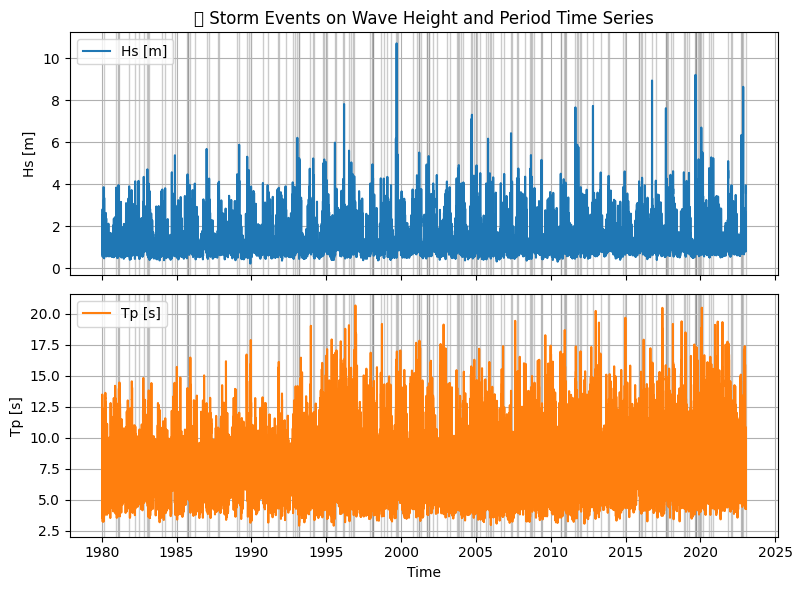

In [38]:
# Plot Hs and Tp with storm events shaded
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# --- Top Panel: Wave Height (Hs) ---
axs[0].plot(buoy_df['time'], buoy_df['VHM0'], label='Hs [m]', color='tab:blue')
axs[0].set_ylabel('Hs [m]')
axs[0].set_title('📈 Storm Events on Wave Height and Period Time Series')
axs[0].grid(True)

# --- Bottom Panel: Wave Period (Tp) ---
axs[1].plot(buoy_df['time'], buoy_df['VTPK'], label='Tp [s]', color='tab:orange')
axs[1].set_ylabel('Tp [s]')
axs[1].set_xlabel('Time')
axs[1].grid(True)

# --- Overlay storm intervals ---
for _, row in event_summary.iterrows():
    for ax in axs:
        ax.axvspan(row['start_time'], row['end_time'], color='k', alpha=0.2)

# Add legends
axs[0].legend()
axs[1].legend()

# Save and show
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'storm_event_overlay_plot.png'), dpi=300)
plt.show()

## 📊 Storm Statistics and Return Periods

Now that we've identified storm events, we can compute key statistics:

---

### 🔢 Number of Storms per Year

We count how many extreme storms (99th percentile) occurred each year. This helps detect:
- Years with unusually high or low activity
- Possible long-term trends in storminess

📈 A bar chart shows the number of storms per year.

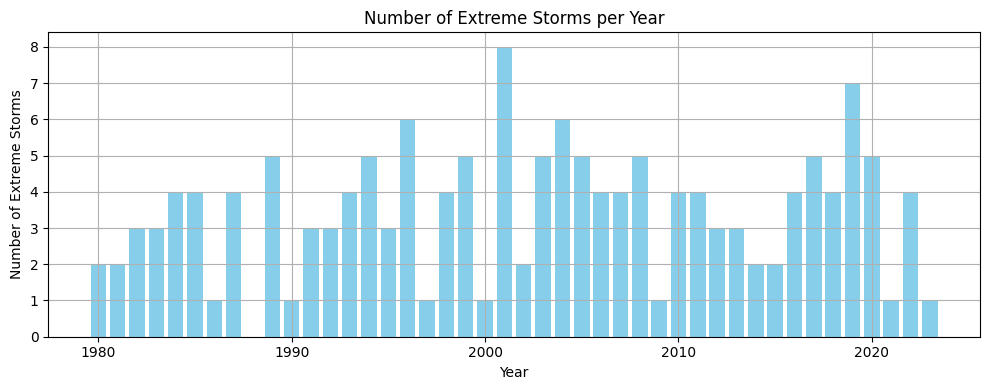

In [39]:
# Convert to datetime (if not already)
event_summary['start_time'] = pd.to_datetime(event_summary['start_time'])

# Extract year and count events per year
event_summary['year'] = event_summary['start_time'].dt.year
storms_per_year = event_summary.groupby('year').size().reset_index(name='storm_count')

# Plot
plt.figure(figsize=(10, 4))
plt.bar(storms_per_year['year'], storms_per_year['storm_count'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Extreme Storms')
plt.title('Number of Extreme Storms per Year')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'storms_per_year.png'), dpi=300)
plt.show()

## 📈 Return Level Estimation: Gumbel vs GEV + Confidence Intervals

After computing annual wave maxima, we estimate **return levels** using two statistical models:

---

### 1️⃣ Gumbel Distribution (EV Type I)
- Classic approach for modeling annual extremes
- Simpler, widely used in engineering

### 2️⃣ Generalized Extreme Value (GEV) Distribution
- More flexible (adds a shape parameter)
- Can better fit heavy or light tails

We compute return levels for return periods from 1 to 100 years.

---

### 📊 Confidence Intervals

To account for uncertainty in the fit, we perform **bootstrapping** to estimate 95% confidence bands for the Gumbel return levels.

---

### 📁 Exports

- 📈 Plot: `return_period_gumbel_gev_ci.png`
- 📄 Data: `return_levels_gumbel.csv` (includes both Gumbel & GEV fits)

> These results are essential for coastal hazard assessment, engineering design, and understanding the risk of extreme wave events.

✅ Return level data exported to:
output_data/return_levels_gumbel_gev.csv


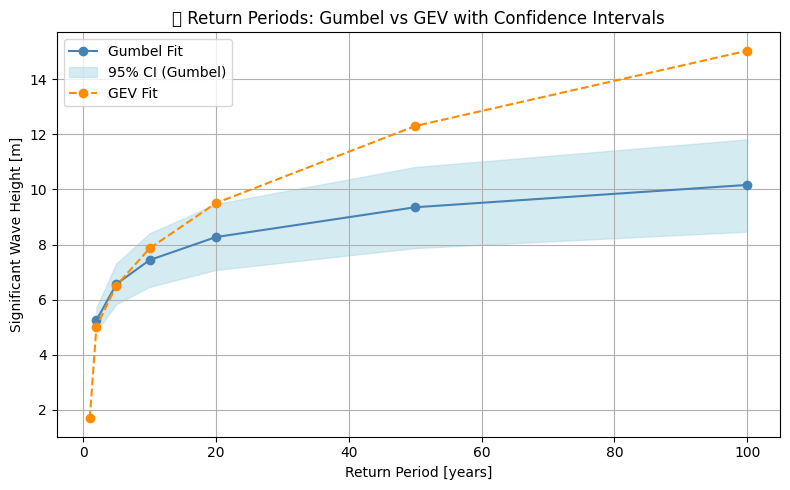

In [40]:
# --- Extract annual maxima ---
buoy_df['year'] = buoy_df['time'].dt.year  # Extract year from datetime
annual_maxima = buoy_df.groupby('year')['VHM0'].max().dropna()  # One max value per year

# --- Define return periods and probabilities ---
return_periods = np.array([1, 2, 5, 10, 20, 50, 100])
exceedance_probs = 1 - 1 / return_periods

# --- Fit Gumbel distribution (Extreme Value Type I) ---
gumbel_loc, gumbel_scale = gumbel_r.fit(annual_maxima)
return_levels_gumbel = gumbel_r.ppf(exceedance_probs, loc=gumbel_loc, scale=gumbel_scale)

# --- Fit GEV distribution (Generalized Extreme Value) ---
gev_shape, gev_loc, gev_scale = genextreme.fit(annual_maxima)
return_levels_gev = genextreme.ppf(exceedance_probs, c=gev_shape, loc=gev_loc, scale=gev_scale)

# --- Bootstrap Gumbel CI ---
n_boot = 1000
bootstrap_levels = []

for _ in range(n_boot):
    resample = annual_maxima.sample(frac=1, replace=True)
    loc_b, scale_b = gumbel_r.fit(resample)
    levels_b = gumbel_r.ppf(exceedance_probs, loc=loc_b, scale=scale_b)
    bootstrap_levels.append(levels_b)

bootstrap_levels = np.array(bootstrap_levels)
ci_lower = np.percentile(bootstrap_levels, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_levels, 97.5, axis=0)

# --- Build return level DataFrame ---
return_df = pd.DataFrame({
    'Return Period [years]': return_periods,
    'Exceedance Probability': exceedance_probs,
    'Return Level (Gumbel) [m]': return_levels_gumbel,
    'Return Level (GEV) [m]': return_levels_gev,
    'CI Lower (Gumbel) [m]': ci_lower,
    'CI Upper (Gumbel) [m]': ci_upper
})

# --- Export to CSV ---
return_csv_path = os.path.join('output_data', 'return_levels_gumbel_gev.csv')
return_df.to_csv(return_csv_path, index=False)
print(f"✅ Return level data exported to:\n{return_csv_path}")

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(return_periods, return_levels_gumbel, 'o-', label='Gumbel Fit', color='steelblue')
plt.fill_between(return_periods, ci_lower, ci_upper, color='lightblue', alpha=0.5, label='95% CI (Gumbel)')
plt.plot(return_periods, return_levels_gev, 'o--', label='GEV Fit', color='darkorange')

plt.xlabel('Return Period [years]')
plt.ylabel('Significant Wave Height [m]')
plt.title('📈 Return Periods: Gumbel vs GEV with Confidence Intervals')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(img_dir, 'return_period_gumbel_gev_ci.png'), dpi=300)
plt.show()

## 🌊 Temporal Patterns in Wave Height, Period, and Direction

In this section, we explore how **wave height**, **wave period**, and **wave direction** vary over time.  
These visualizations help us understand **seasonal patterns**, **long-term trends**, and possible **climate shifts** in wave behavior.

---

### 1️⃣ Monthly Mean Wave Height (Hs)

We calculate the average **significant wave height** for each month across all available years.  
The result is a heatmap showing how Hs changes seasonally and whether specific years stand out as more energetic.

🗂️ Output: `heatmap_monthly_mean_Hs.png`

---

### 2️⃣ Monthly Mean Peak Period (Tp)

Similarly, we compute the **peak wave period** for each month and visualize it over time.  
This helps identify periods with longer swell conditions vs shorter, more wind-driven seas.

🗂️ Output: `heatmap_monthly_mean_Tp.png`

---

### 3️⃣ Annual Wave Direction Distribution

We bin the **wave direction** (`VMDR`) into 8 compass sectors (N, NE, E, SE, S, SW, W, NW).  
Then, we calculate the **frequency of waves from each direction** per year and visualize that as a heatmap.

This gives insight into:
- Shifts in dominant wave directions 🧭
- Interannual variability in wave climate

🗂️ Output: `heatmap_wave_direction_by_year.png`

---

> These visual summaries help us detect patterns that may relate to seasonal winds, swell propagation, or climate variability (e.g., ENSO years).

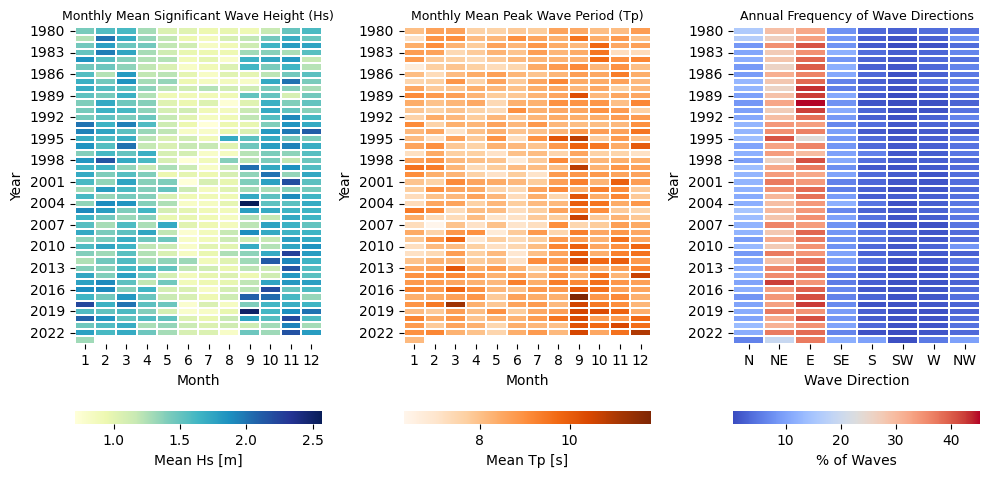

✅ Combined figure saved to:
output_images/combined_wave_statistics_heatmaps.png


In [41]:
# --- Prepare monthly mean Hs ---
buoy_df['year'] = buoy_df['time'].dt.year
buoy_df['month'] = buoy_df['time'].dt.month

hs_monthly = buoy_df.pivot_table(values='VHM0', index='year', columns='month', aggfunc='mean')

# --- Prepare monthly mean Tp ---
tp_monthly = buoy_df.pivot_table(values='VTPK', index='year', columns='month', aggfunc='mean')

# --- Prepare wave direction frequencies ---
direction_labels = ['N','NE','E','SE','S','SW','W','NW']
buoy_df['dir_sector'] = pd.cut(
    buoy_df['VMDR'] % 360,
    bins=np.linspace(0, 360, 9),
    labels=direction_labels,
    include_lowest=True,
    right=False
)

dir_freq = buoy_df.groupby(['year', 'dir_sector']).size().unstack(fill_value=0)
dir_freq_percent = dir_freq.div(dir_freq.sum(axis=1), axis=0) * 100

# --- Plot combined figure ---
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Panel 1: Hs
sns.heatmap(hs_monthly, cmap='YlGnBu', ax=axs[0], cbar_kws={'orientation': 'horizontal', 'label': 'Mean Hs [m]'}, linewidths=0.3)
axs[0].set_title('Monthly Mean Significant Wave Height (Hs)', fontsize=9)
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Year')

# Panel 2: Tp
sns.heatmap(tp_monthly, cmap='Oranges', ax=axs[1], cbar_kws={'orientation': 'horizontal', 'label': 'Mean Tp [s]'}, linewidths=0.3)
axs[1].set_title('Monthly Mean Peak Wave Period (Tp)', fontsize=9)
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Year')

# Panel 3: Direction frequency
sns.heatmap(dir_freq_percent, cmap='coolwarm', ax=axs[2], cbar_kws={'orientation': 'horizontal', 'label': '% of Waves'}, linewidths=0.3)
axs[2].set_title('Annual Frequency of Wave Directions', fontsize=9)
axs[2].set_xlabel('Wave Direction')
axs[2].set_ylabel('Year')

plt.tight_layout()
combined_path = os.path.join(img_dir, 'combined_wave_statistics_heatmaps.png')
plt.savefig(combined_path, dpi=300)
plt.show()

print(f"✅ Combined figure saved to:\n{combined_path}")

## 📉 Monthly Anomaly Maps (Hs and Tp)

To better detect **unusual wave conditions**, we calculate anomalies:
- Each month is compared to the **long-term climatological mean** for that same month
- Values above/below the average stand out clearly

This approach removes the **seasonal cycle**, helping identify:
- Anomalously stormy or calm months
- Effects of climate drivers (e.g., El Niño, NAO)
- Trends in seasonal intensity

---

### 🔹 Hs Anomalies

`Observed Hs monthly average` – `long-term Hs monthly climatology`

🗂️ Output: `heatmap_monthly_Hs_anomalies.png`

---

### 🔹 Tp Anomalies

Same as above, but using **peak wave period**.

🗂️ Output: `heatmap_monthly_Tp_anomalies.png`

---

> These heatmaps help detect shifts and outliers in wave energy and period that would otherwise be masked by regular seasonal variation.

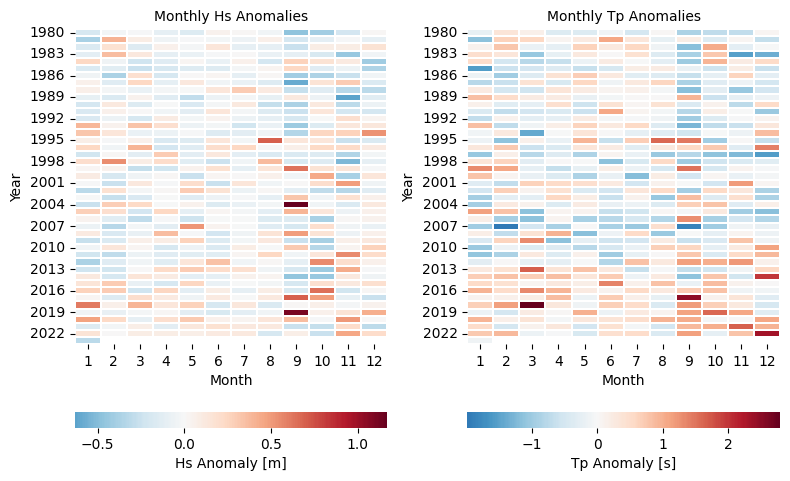

✅ Anomaly figure saved to:
output_images/combined_wave_anomaly_heatmaps.png


In [42]:
# --- Monthly Climatology and Anomalies for Hs ---
hs_climatology = buoy_df.groupby('month')['VHM0'].mean()
hs_monthly = buoy_df.pivot_table(values='VHM0', index='year', columns='month', aggfunc='mean')
hs_anomalies = hs_monthly - hs_climatology

# --- Monthly Climatology and Anomalies for Tp ---
tp_climatology = buoy_df.groupby('month')['VTPK'].mean()
tp_monthly = buoy_df.pivot_table(values='VTPK', index='year', columns='month', aggfunc='mean')
tp_anomalies = tp_monthly - tp_climatology

# --- Plot both anomaly heatmaps ---
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

# Panel 1: Hs anomaly
sns.heatmap(hs_anomalies, cmap='RdBu_r', center=0, ax=axs[0],
            cbar_kws={'orientation': 'horizontal', 'label': 'Hs Anomaly [m]'}, linewidths=0.3)
axs[0].set_title('Monthly Hs Anomalies', fontsize=10)
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Year')

# Panel 2: Tp anomaly
sns.heatmap(tp_anomalies, cmap='RdBu_r', center=0, ax=axs[1],
            cbar_kws={'orientation': 'horizontal', 'label': 'Tp Anomaly [s]'}, linewidths=0.3)
axs[1].set_title('Monthly Tp Anomalies', fontsize=10)
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Year')

# Save and show
plt.tight_layout()
anomaly_fig_path = os.path.join(img_dir, 'combined_wave_anomaly_heatmaps.png')
plt.savefig(anomaly_fig_path, dpi=300)
plt.show()

print(f"✅ Anomaly figure saved to:\n{anomaly_fig_path}")

## 🌈 Climate Strip Plot – Monthly Evolution of Wave Conditions

To visually track how wave conditions have changed over time, we generate **climate strips** based on monthly averages:

- **Top panel:** Normalized monthly averages of **significant wave height** (Hs)  
- **Bottom panel:** Normalized monthly averages of **peak wave period** (Tp)

These plots help us easily identify **long-term patterns**, **seasonality**, or **abrupt shifts** over the years.

🧮 **How it works:**
1. The data is first resampled to compute **monthly means** for both `Hs` and `Tp`.
2. Each variable is normalized between 0 and 1 (min-max scaling).
3. A colored strip is shown for each month, where **color intensity** indicates relative magnitude.
4. Year labels are shown every 5 years (at January), keeping the visual clean.

📌 These visualizations are inspired by the popular “warming stripe” climate graphics and help reveal long-term change at a glance.

🖼️ **Output saved to:**  
`output_images/climate_stripplot_monthly_Hs_Tp.png`

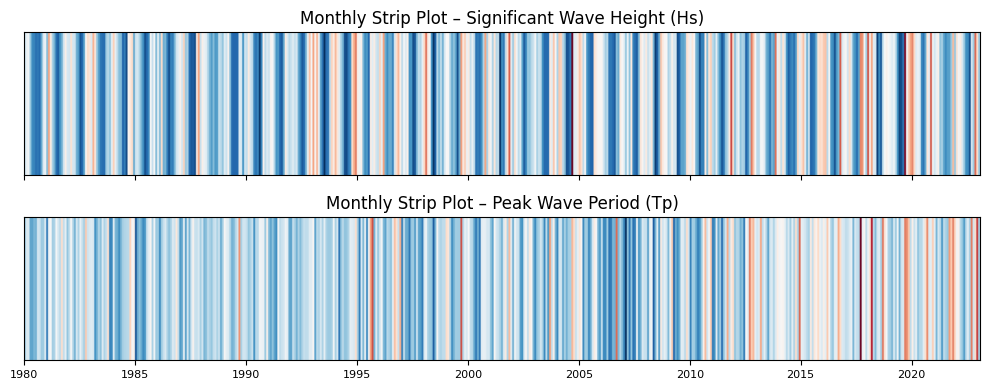

✅ Climate strip figure saved to:
output_images/climate_stripplot_monthly_Hs_Tp.png


In [43]:
import matplotlib.dates as mdates

# Ensure 'time' is the datetime index
if 'time' in buoy_df.columns:
    buoy_df['time'] = pd.to_datetime(buoy_df['time'])
    buoy_df = buoy_df.set_index('time')

# Resample to monthly means
monthly_means = buoy_df[['VHM0', 'VTPK']].resample('M').mean()

# Normalize each variable between 0–1 for color mapping
hs_norm = (monthly_means['VHM0'] - monthly_means['VHM0'].min()) / (monthly_means['VHM0'].max() - monthly_means['VHM0'].min())
tp_norm = (monthly_means['VTPK'] - monthly_means['VTPK'].min()) / (monthly_means['VTPK'].max() - monthly_means['VTPK'].min())

# Get the monthly index
months = monthly_means.index

# Identify label positions: only January every 5 years
label_positions = [i for i, date in enumerate(months) if (date.month == 1 and date.year % 5 == 0)]
label_years = [months[i].year for i in label_positions]

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

# Strip plot for Hs
axs[0].imshow([hs_norm], aspect='auto', cmap='RdBu_r', extent=[0, len(months), 0, 1])
axs[0].set_yticks([])
axs[0].set_xticks(label_positions)
axs[0].set_xticklabels(label_years, fontsize=8)
axs[0].set_title('Monthly Strip Plot – Significant Wave Height (Hs)')

# Strip plot for Tp
axs[1].imshow([tp_norm], aspect='auto', cmap='RdBu_r', extent=[0, len(months), 0, 1])
axs[1].set_yticks([])
axs[1].set_xticks(label_positions)
axs[1].set_xticklabels(label_years, fontsize=8)
axs[1].set_title('Monthly Strip Plot – Peak Wave Period (Tp)')

plt.tight_layout()
strip_path = os.path.join(img_dir, 'climate_stripplot_monthly_Hs_Tp.png')
plt.savefig(strip_path, dpi=300)
plt.show()

print(f"✅ Climate strip figure saved to:\n{strip_path}")

---

## 📝 Acknowledgments

This script was developed by **Alessio Rovere** at **Ca' Foscari University of Venice**, with the support of **ChatGPT by OpenAI** for code structuring, optimization, and documentation refinement.

This work is part of the **WARMCOASTS** project, funded by the **European Research Council (ERC)** under the European Union’s Horizon 2020 research and innovation programme (grant agreement n. **802414**).

⚠️ **Disclaimer:**  
The code is provided *as is*, without any warranties or guarantees of correctness. Users are responsible for verifying results and adapting the scripts to their specific needs. Neither the authors nor the European Union can be held responsible for any use that may be made of the information or code contained herein.